#### Imports

In [205]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link, convert_ISO_3166_2_to_1, generation, generation_links, market_values_storage_units, generation_storage_units

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [206]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [207]:
carriers_buses = n.buses.carrier.unique().tolist()
carriers_gens = n.generators.carrier.unique().tolist()
carriers_links = n.links.carrier.unique().tolist()
carriers_buses
carriers_gens
carriers_links

['DC',
 'OCGT',
 'H2 Electrolysis',
 'H2 Fuel Cell',
 'battery charger',
 'battery discharger',
 'Sabatier',
 'SMR CC',
 'SMR',
 'BEV charger',
 'V2G',
 'residential rural ground heat pump',
 'residential rural water tanks charger',
 'residential rural water tanks discharger',
 'residential rural resistive heater',
 'residential rural gas boiler',
 'services rural ground heat pump',
 'services rural water tanks charger',
 'services rural water tanks discharger',
 'services rural resistive heater',
 'services rural gas boiler',
 'residential urban decentral air heat pump',
 'residential urban decentral water tanks charger',
 'residential urban decentral water tanks discharger',
 'residential urban decentral resistive heater',
 'residential urban decentral gas boiler',
 'services urban decentral air heat pump',
 'services urban decentral water tanks charger',
 'services urban decentral water tanks discharger',
 'services urban decentral resistive heater',
 'services urban decentral gas b

In [208]:
# sort carriers by similar technology / underlying energy for better investigation
car_bus_el = ['AC','battery','Li ion','low voltage','home battery' ]
car_bus_heat = ['residential rural heat', 'services rural heat','residential urban decentral heat', 'services urban decentral heat', 'urban central heat']
car_bus_bio_gas = ['H2','biogas','solid biomass','solid biomass for industry','gas for industry','H2 liquid']

car_gen_vre = ['offwind-ac', 'offwind-dc','onwind', 'solar', 'ror', 'solar rooftop']
car_gen_soltherm = [ 'residential rural solar thermal', 'services rural solar thermal', 'residential urban decentral solar thermal', 'services urban decentral solar thermal','urban central solar thermal',]

car_link_imp1 = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger"]
car_link_imp2 = ["OCGT", "H2 Electrolysis", "Fischer-Tropsch","Sabatier", "H2 Fuel Cell", "urban central gas CHP", "urban central gas CHP CC", "battery charger", "battery discharger", "home battery charger", "home battery discharger"   ]
car_link_mix = ['OCGT', 'H2 Electrolysis', 'H2 Fuel Cell', 'Sabatier', 'SMR', "Fischer-Tropsch", "urban central gas CHP", "battery charger", "battery discharger", "residential rural resistive heater","residential rural ground heat pump","residential rural gas boiler"]
car_link_resisitve_heater = ["residential rural resistive heater", "services rural resistive heater", "residential urban decentral resistive heater", "services urban decentral resistive heater", "urban central resistive heater" ]
car_link_heat_pumps = ["residential rural ground heat pump", "services rural ground heat pump", "residential urban decentral air heat pump", "services urban decentral air heat pump", "urban central air heat pump"  ]
car_link_gas_boiler = ["residential rural gas boiler", "services rural gas boiler", "residential urban decentral gas boiler", "services urban decentral gas boiler", "urban central gas boiler"]

#### General Investigation

In [209]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [210]:
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers_gens)

for carrier in carriers_gens:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

offwind-ac      onwind      solar         ror  offwind-dc        gas  \
AL0 0  126.148417  131.075254  44.628736         NaN         NaN        NaN   
AT0 0         NaN   83.457109  54.679083   87.946522         NaN        NaN   
AT0 1         NaN   84.612302  65.745903   97.282183         NaN        NaN   
AT0 2         NaN   90.012931  58.223787   85.291980         NaN        NaN   
BA0 0         NaN  119.715551  51.160537         NaN         NaN        NaN   
...           ...         ...        ...         ...         ...        ...   
SE3 6   60.483666   53.277864  58.963028   77.032750   60.000468        NaN   
SE3 7   59.877949   63.297661  60.256194   66.164361   60.578980        NaN   
SI0 0  148.386481  125.246390  60.556211  111.663140         NaN        NaN   
SK0 0         NaN   91.144751  54.957441   93.823663         NaN        NaN   
EU            NaN         NaN        NaN         NaN         NaN  20.109146   

       residential rural solar thermal  services rural solar thermal  \
AL0 0                        28.100521                     28.138751   
AT0 0                        25.297088                     25.674329   
AT0 1                        48.136420                     48.114128   
AT0 2                        36.920372                     36.785644   
BA0 0                        27.930405                     26.504637   
...                                ...                           ...   
SE3 6                        36.445496                     36.991150   
SE3 7                        28.425435                     27.717632   
SI0 0                        28.066113                     26.536094   
SK0 0                        21.491470                     22.449092   
EU                                 NaN                           NaN   

       residential urban decentral solar thermal  \
AL0 0                                  36.469361   
AT0 0                                  34.858212   
AT0 1                                  57.898941   
AT0 2                                  50.714563   
BA0 0                                  37.326041   
...                                          ...   
SE3 6                                  42.670140   
SE3 7                                   6.907004   
SI0 0                                  36.636030   
SK0 0                                  29.961099   
EU                                           NaN   

       services urban decentral solar thermal  urban central solar thermal  \
AL0 0                               35.507220                    45.096866   
AT0 0                               34.521443                    39.641186   
AT0 1                               58.635892                    38.246840   
AT0 2                               49.973918                    40.517487   
BA0 0                               36.184464                    33.059630   
...                                       ...                          ...   
SE3 6                               41.596612                    38.443884   
SE3 7                               20.114828                    35.763463   
SI0 0                               35.702336                    39.247357   
SK0 0                               28.937610                    34.316675   
EU                                        NaN                          NaN   

             oil  solar rooftop  
AL0 0        NaN      56.499070  
AT0 0        NaN      64.462333  
AT0 1        NaN      77.031453  
AT0 2        NaN      69.284880  
BA0 0        NaN      58.363750  
...          ...            ...  
SE3 6        NaN      68.822199  
SE3 7        NaN      63.005445  
SI0 0        NaN      62.729094  
SK0 0        NaN      61.104808  
EU     50.009981            NaN  

[182 rows x 13 columns]

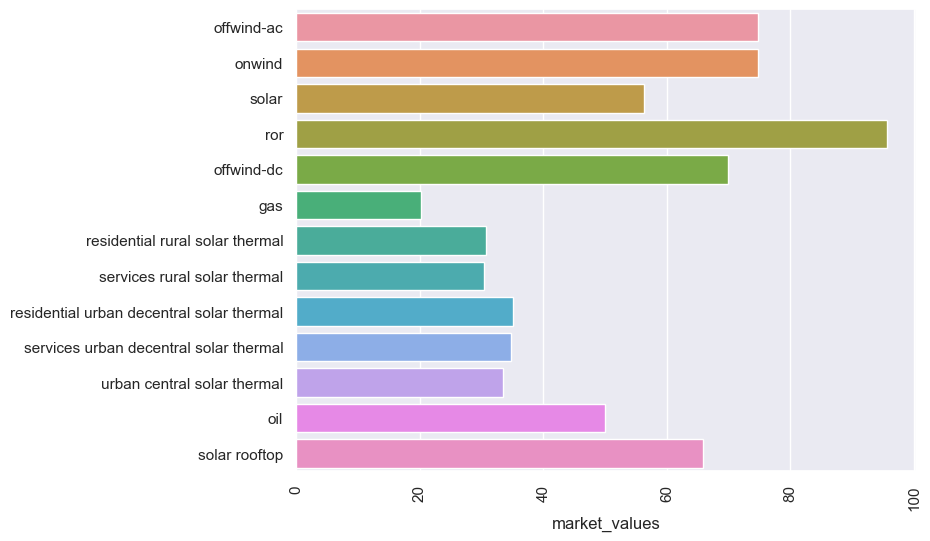

In [211]:
# plot overall market value for all carriers
mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

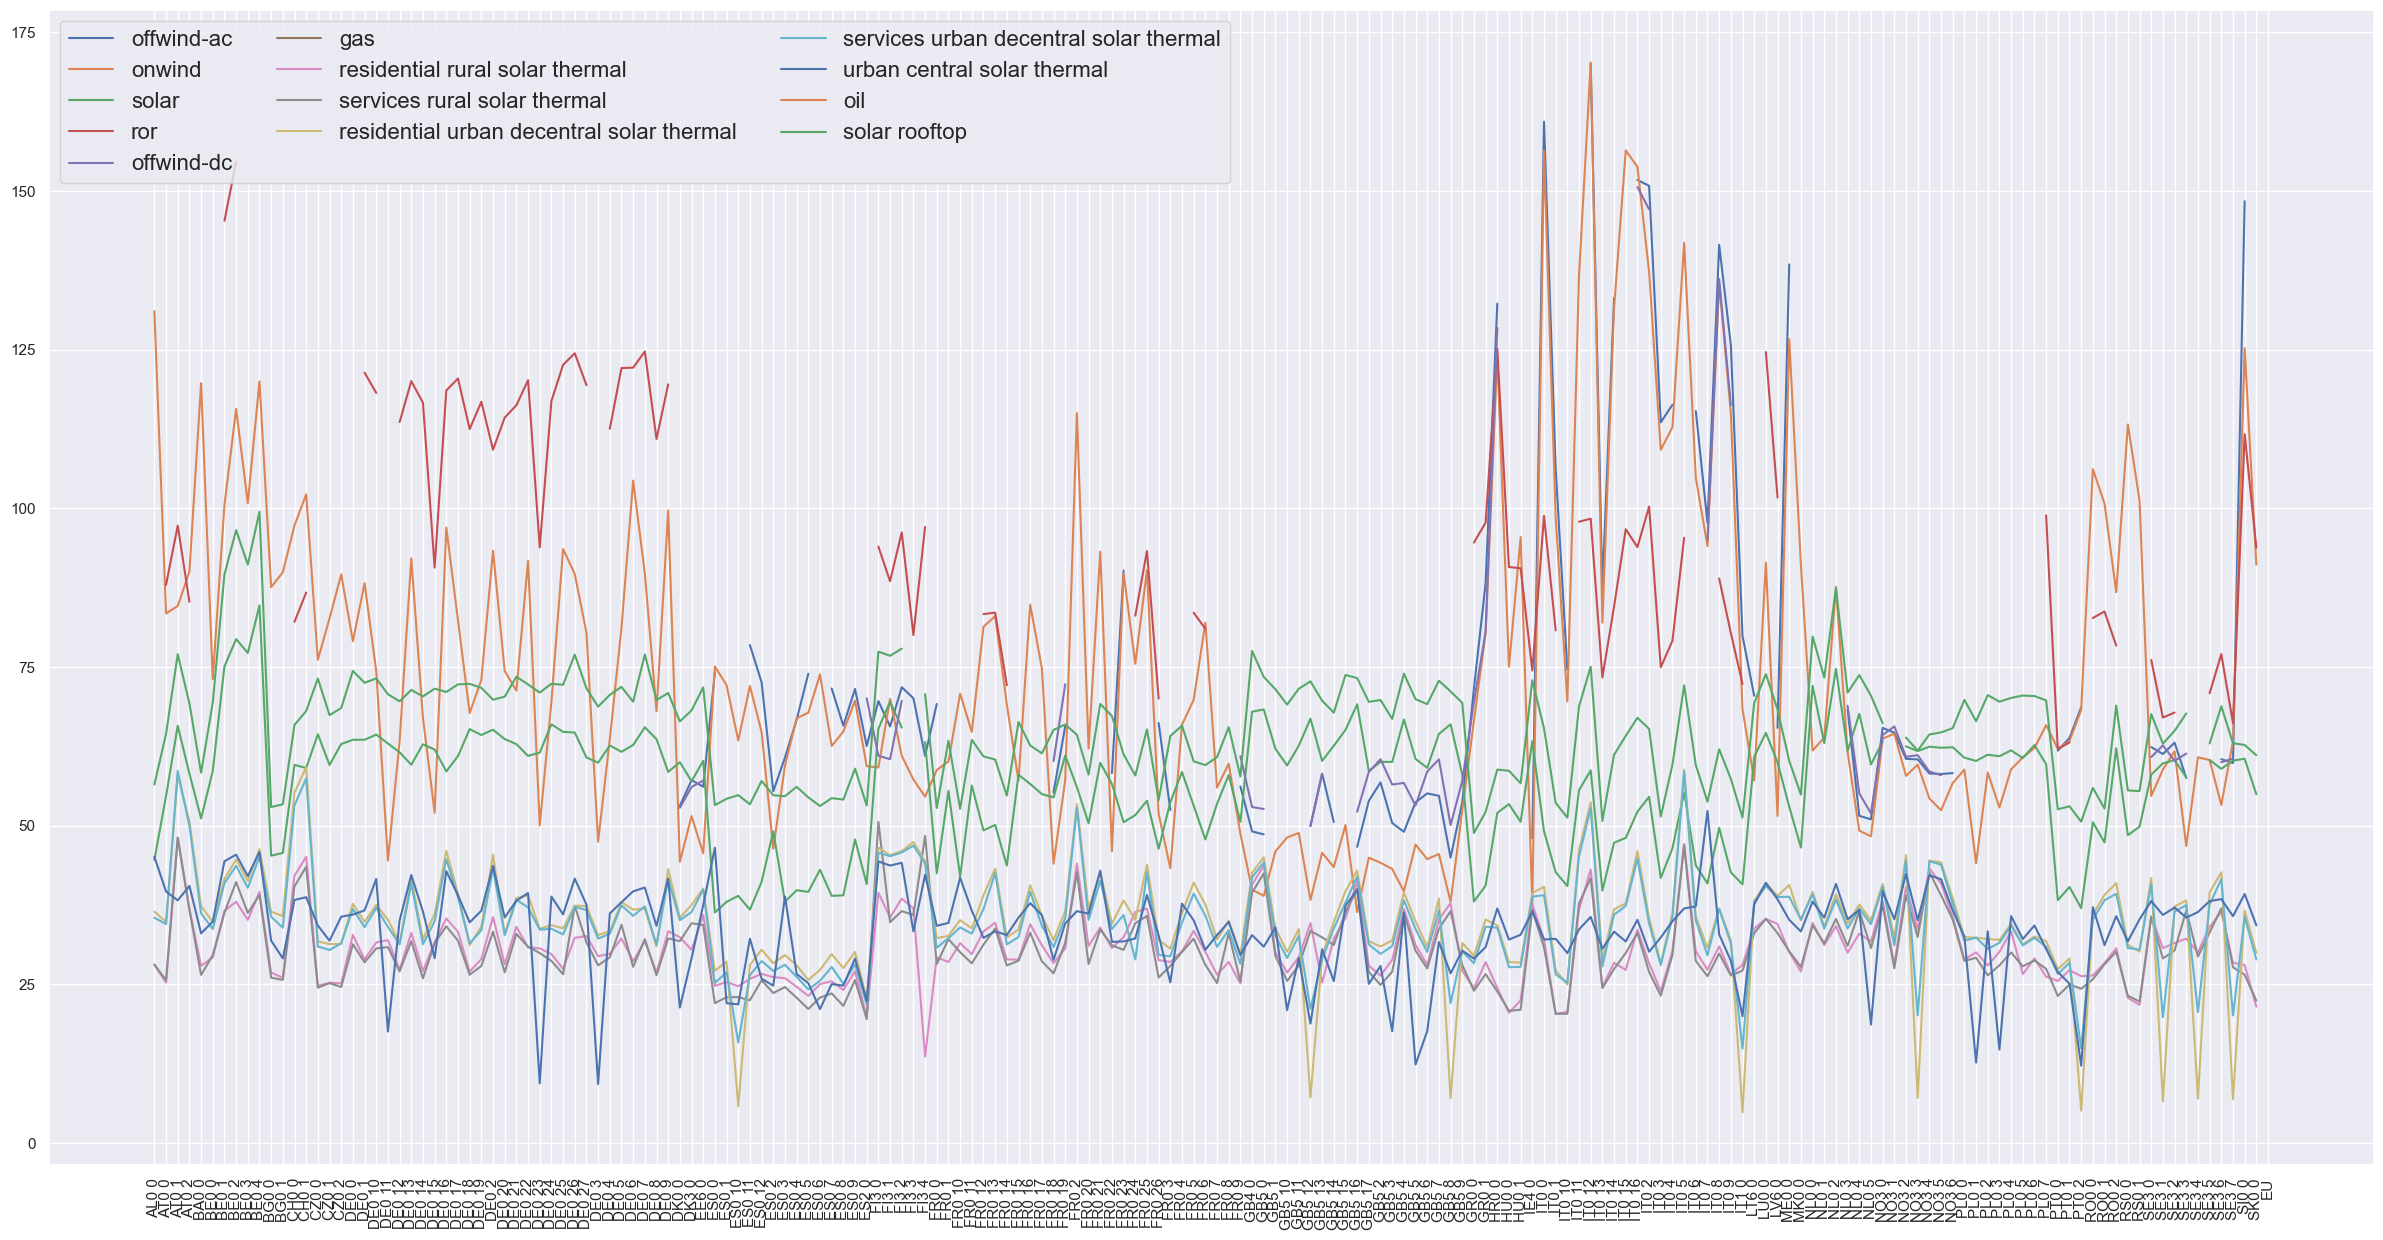

In [212]:
# market value of all carriers for all 181 regions
ax = mv_carriers.plot(figsize=(30,15))
plt.legend(loc='upper left', ncol=3, prop={'size': 16})
ax.set_xticks(range(len(mv_carriers)))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.index.tolist()], rotation=90)

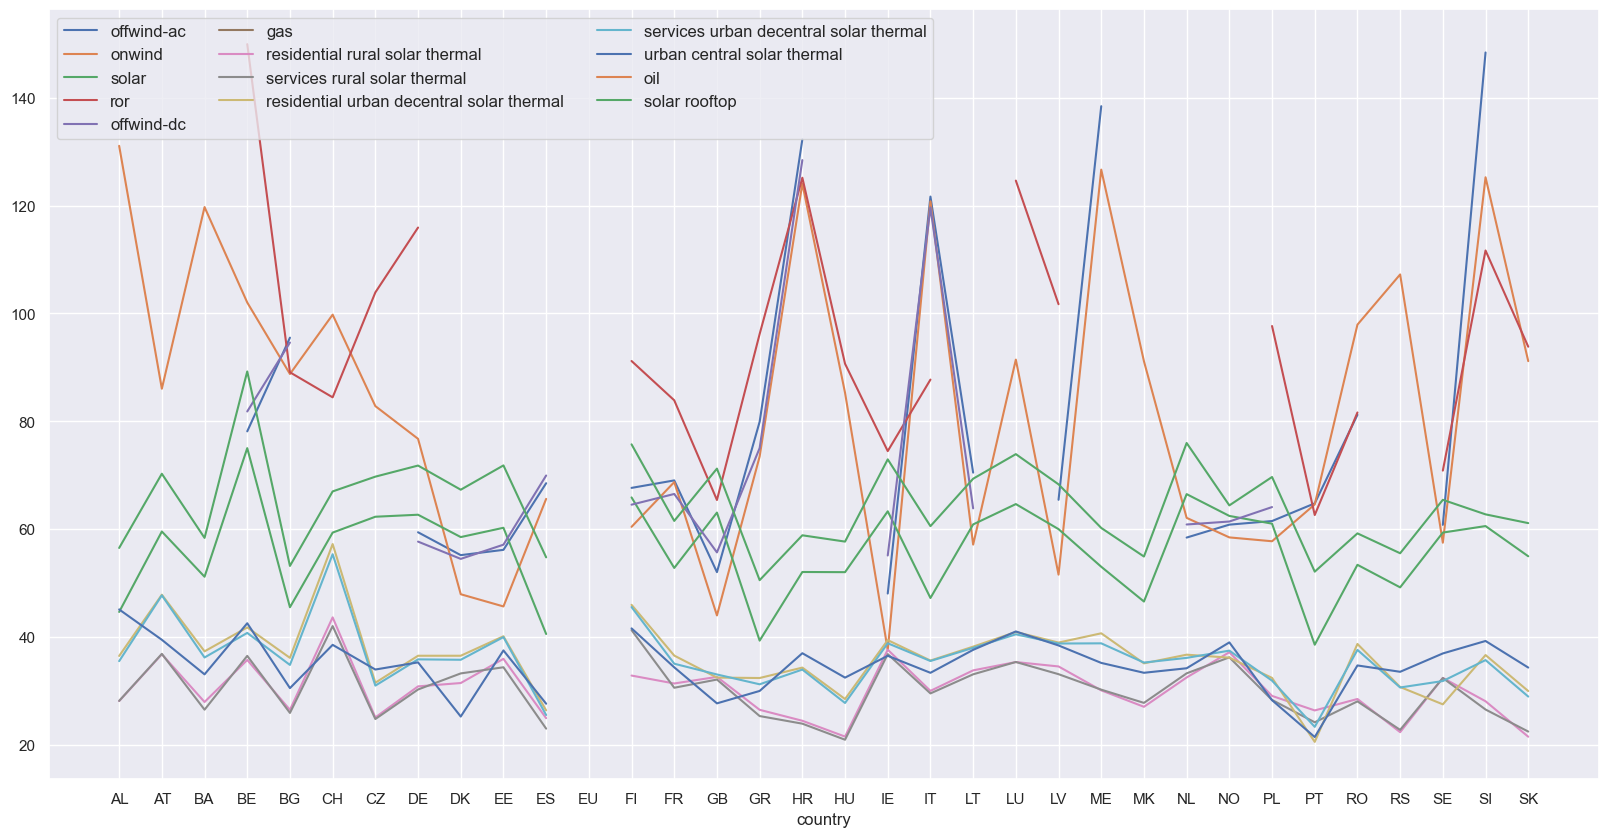

In [213]:
# Plot of mv of carriers by country
mv_carriers["country"] = mv_carriers.index.str[:2]
ax = mv_carriers.groupby(by="country").mean().plot(figsize=(20,10))
plt.legend(loc='upper left', ncol=3, prop={'size': 12})
ax.set_xticks(range(len(mv_carriers.groupby(by="country").mean())))
ticks = ax.set_xticklabels(labels = [item for item in mv_carriers.groupby(by="country").mean().index.tolist()], rotation=0)

In [214]:
# # Plot of market values of carriers for periods
days = pd.DatetimeIndex(np.unique(n.generators_t.p.index.date))
# plt.figure(figsize=(15, 10))
#
# for carrier in car_gen_vre:
#     mv = market_values_by_time_index(n, days, carrier)
#     plt.plot(mv.mean(axis=1), label=carrier)
#
# plt.legend()

In [215]:
# # Plot of all locational marginal prices over all carriers per regions
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
# df1 = lmp_regions.mean()
# sns.set(rc={'figure.figsize':(10,30)})
# ax = sns.barplot(y=df1.index, x=df1.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

In [216]:
# # Plot of lmp over all carriers averaged over countries
# df2 = lmp_regions.transpose()
# df2["country"] = df2.index.str[:2]
# df2 = df2.groupby(by="country").mean().mean(axis=1)
# sns.set(rc={'figure.figsize':(10,7)})
# ax = sns.barplot(y=df2.index, x=df2.values)
#
# for i in ax.containers:
#     ax.bar_label(i,)

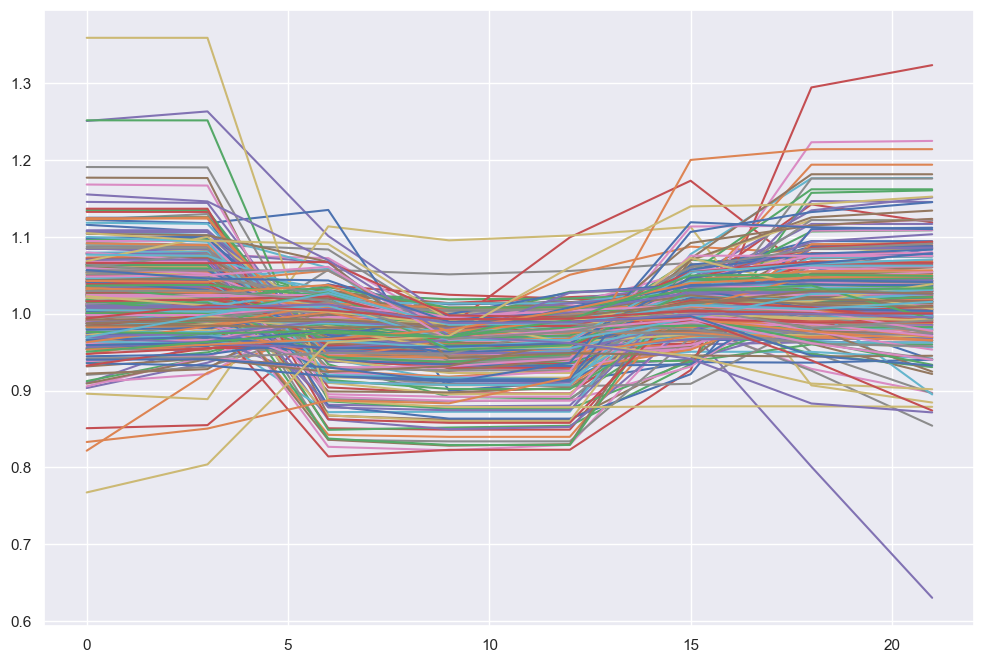

In [217]:
# Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the day
plt.figure(figsize=(12, 8))

carrier_bus = "H2" #carriers_buses
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index]

for day in days:
    df = lmps[lmps.index.date == day.date()].mean(axis=1)
    df_normalized = df / df.mean()
    plt.plot(df_normalized.index.hour, df_normalized.values)

<AxesSubplot: xlabel='hour_of_day', ylabel='lmp_normalized'>

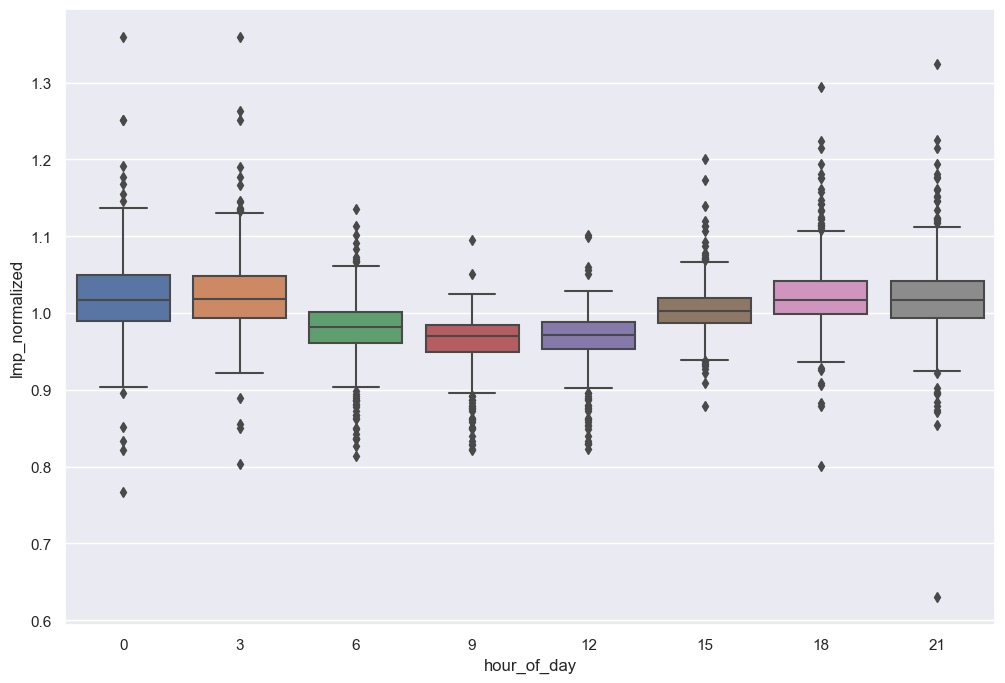

In [218]:
# # Plot of lmp daily pattern of lmps over all carriers normalized by the mean price of the current day
plt.figure(figsize=(12, 8))
df3 = pd.DataFrame(lmps.mean(axis=1))
df3.columns = ["lmp"]
df3["lmp_normalized"] = np.nan

for snap in df3.index:
    df3.loc[snap, "lmp_normalized"] = df3.loc[snap, "lmp"] / df3[df3.index.date == snap.date()].lmp.mean()

df3["hour_of_day"] = df3.index.hour
sns.boxplot(data=df3, y="lmp_normalized", x="hour_of_day")

### Spatial distribution of market values per technology

#### Regions

In [219]:
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

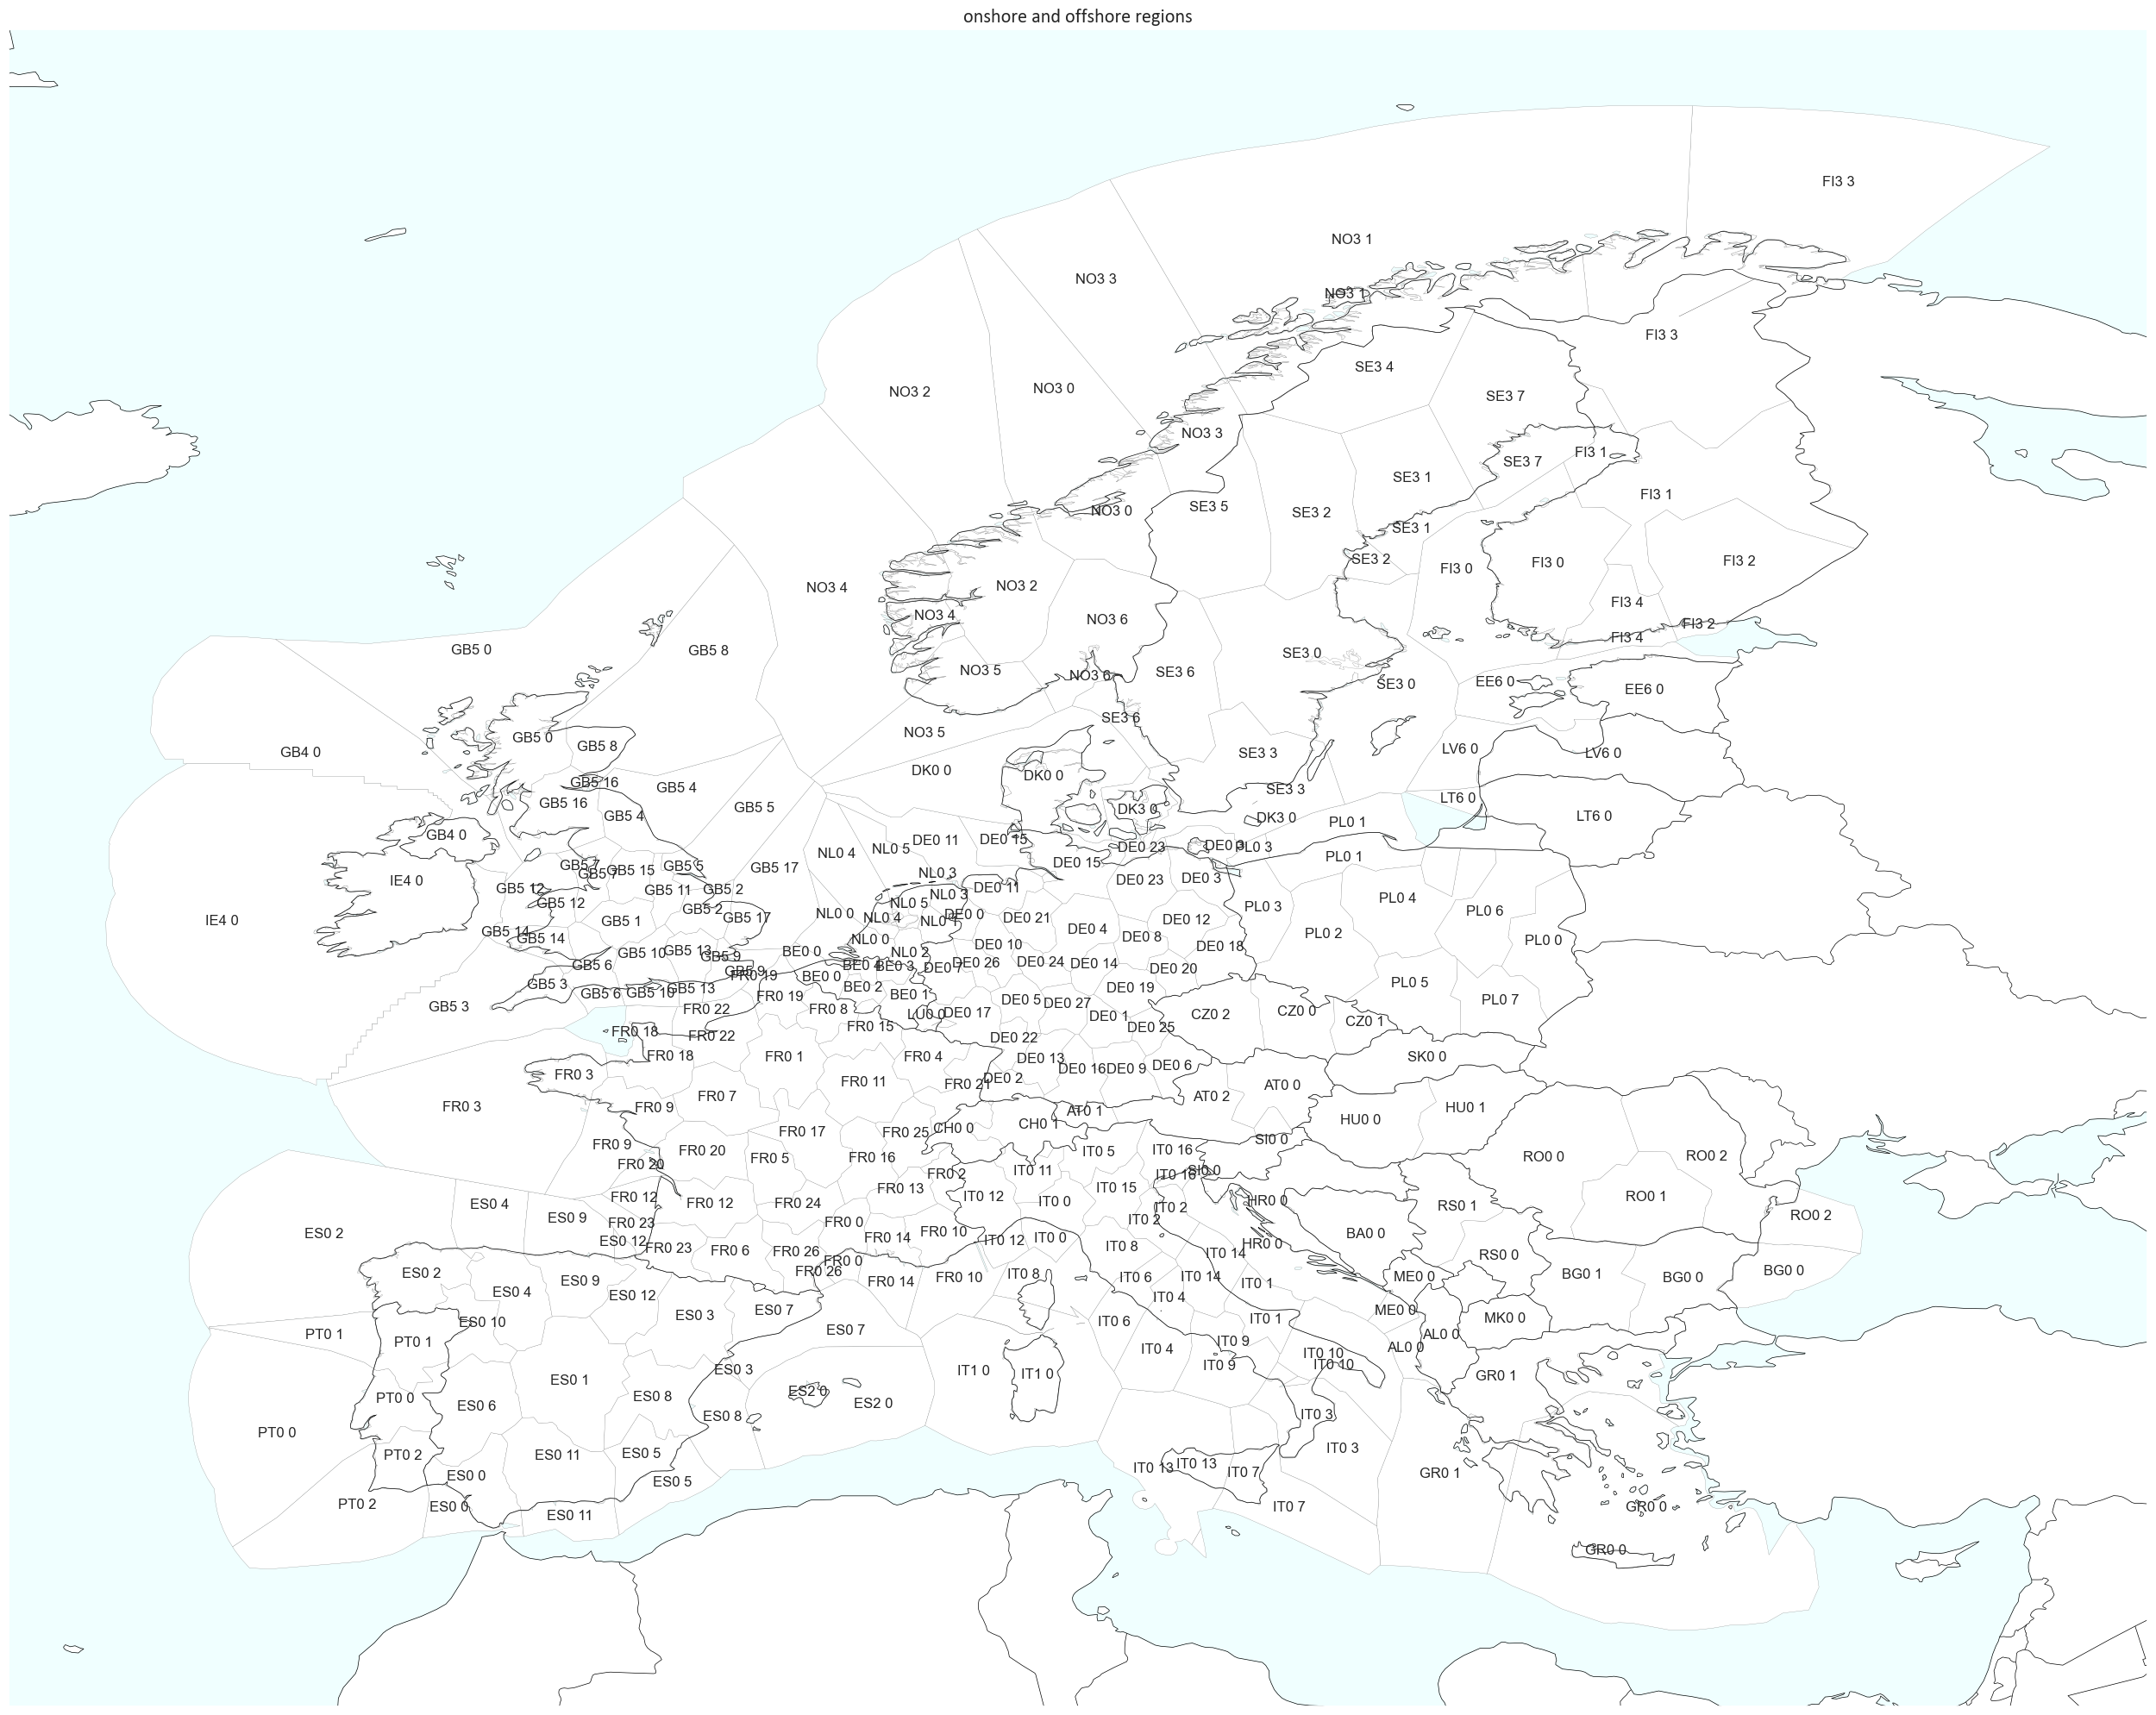

In [220]:
fig = plt.figure(figsize=(32, 26))
crs = ccrs.PlateCarree()

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("onshore and offshore regions", fontsize=16, **font1)

onshore_regions.to_crs(crs.proj4_init).plot(ax=ax,
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

offshore_regions.to_crs(crs.proj4_init).plot(ax=ax,
                     linewidth=0.2,
                     facecolor="white",
                     edgecolor = 'grey')

for idx, row in onshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

for idx, row in offshore_regions.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.show()
# plt.close()

In [221]:
# fig.savefig(f"{PLOT_DIR}01_general/regions.png")

#### Market value per region

In [222]:
mv_regions_onshore = onshore_regions.copy()
mv_regions_offshore = offshore_regions.copy()

# function for carriers in n.generators.carrier.unique() #13
for carrier in n.generators.carrier.unique():
    mv_regions_onshore[carrier] = market_values(n, carrier)
    mv_regions_offshore[carrier] = market_values(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation(n, carrier)
    mv_regions_offshore[f"{carrier}_gen"] = generation(n, carrier)

# function for carriers in n.links.carrier.unique() #53
for carrier in n.links.carrier.unique():
    mv_regions_onshore[carrier] = market_values_links(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier)

# function for carriers in n.storage_units.carrier.unique() #2
for carrier in n.storage_units.carrier.unique():
    mv_regions_onshore[carrier] = market_values_storage_units(n, carrier)
    mv_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier)

# set market values to nan where generation in corresponding region is lower than % quantile
qt = 0.25
for carrier in (n.generators.carrier.unique().tolist() + n.links.carrier.unique().tolist() + n.storage_units.carrier.unique().tolist()):
    index = mv_regions_onshore[f"{carrier}_gen"] <= np.quantile(mv_regions_onshore[f"{carrier}_gen"], qt )
    mv_regions_onshore[carrier][index] = np.nan


mv_regions_onshore.head(3)
# mv_regions_offshore.head(3)
#TODO: Exclude lowest quantile of generation from market values

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords   name  offwind-ac  \
name                                                                 
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0  126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0         NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1         NaN   

       offwind-ac_gen     onwind    onwind_gen      solar     solar_gen  \
name                                                                      
AL0 0        9.746004        NaN  5.041607e+00  44.628736  8.232590e+06   
AT0 0             NaN  83.457109  1.013197e+07  54.679083  3.400489e+06   
AT0 1             NaN        NaN  1.159912e-01  65.745903  5.758750e+06   

             ror  ...  electricity distribution grid  \
name              ...                                  
AL0 0        NaN  ...                            NaN   
AT0 0  87.946522  ...                     117.569587   
AT0 1  97.282183  ...                            NaN   

       electricity distribution grid_gen  home battery charger  \
name                                                             
AL0 0                       1.404385e+06             78.253283   
AT0 0                       2.010033e+07             92.118676   
AT0 1                       2.514475e+06                   NaN   

       home battery charger_gen  home battery discharger  \
name                                                       
AL0 0                322.620159                86.106855   
AT0 0                305.176068               100.313215   
AT0 1                264.978903                      NaN   

       home battery discharger_gen       hydro     hydro_gen         PHS  \
name                                                                       
AL0 0                   316.101874         NaN           NaN         NaN   
AT0 0                   299.010300  146.910893  3.494307e+05         NaN   
AT0 1                   259.625248  161.367883  1.574122e+06  121.261241   

             PHS_gen  
name                  
AL0 0            NaN  
AT0 0            NaN  
AT0 1  555265.574815  

[3 rows x 139 columns]

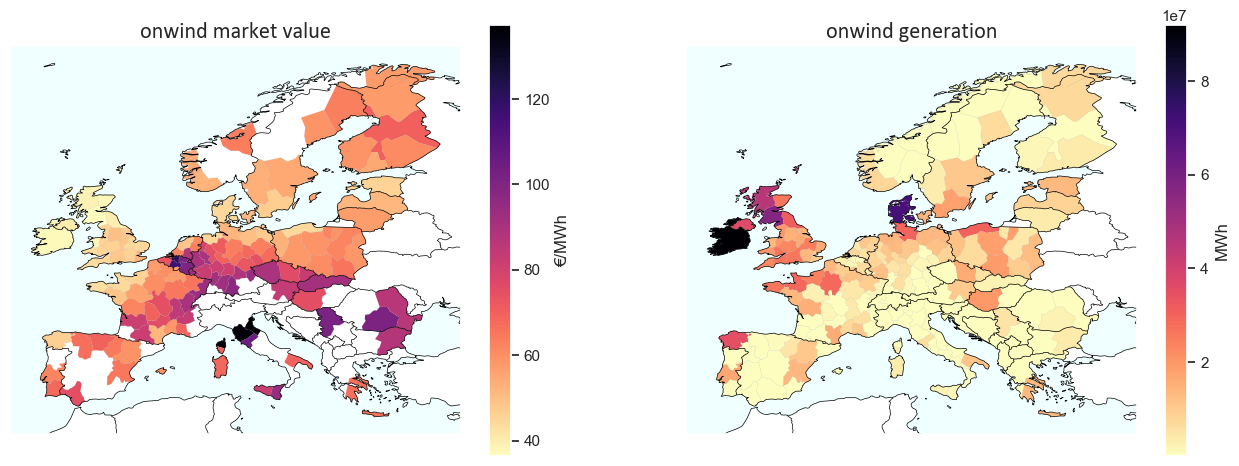

In [223]:
# carrier and generation plot
carrier = "onwind" # ""onwind" # "ror" # "onwind"
labels=[carrier, f"{carrier}_gen"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 14))
crs = ccrs.PlateCarree() #AlbersEqualArea()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if i==0:
        title = f"{carrier} market value"
        label = "€/MWh"
    elif i==1:
        title = f"{carrier} generation"
        label = "MWh"

    mv_regions_onshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':label,
                            'orientation': "vertical",
                                      'shrink' : 0.4})

    ax.set_title(title, fontsize=16, **font1)
plt.show()

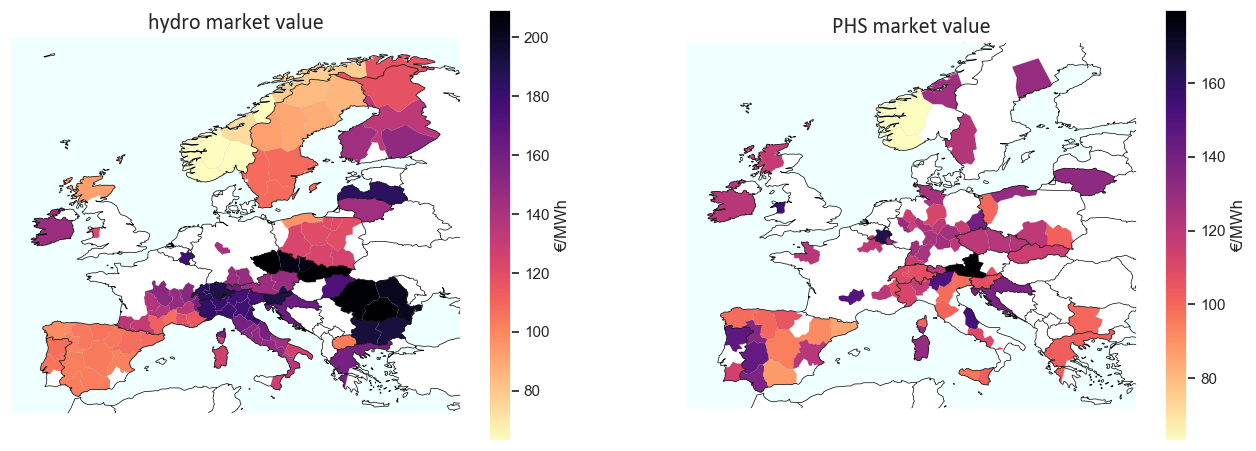

In [224]:
# compare two carriers plot
labels=["hydro", "PHS"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 14))
crs = ccrs.PlateCarree() #AlbersEqualArea()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{labels[i]} market value", fontsize=16, **font1)

    mv_regions_onshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':"€/MWh",
                            'orientation': "vertical",
                                      'shrink' : 0.4})


plt.show()

In [225]:
mv_regions_onshore[labels[0]].sort_values(ascending=False)

name
SK0 0    209.340466
CZ0 2    208.858109
RO0 1    208.561647
RO0 0    207.314828
CZ0 0    203.257265
            ...    
PL0 0           NaN
PL0 3           NaN
PT0 2           NaN
RS0 0           NaN
RS0 1           NaN
Name: hydro, Length: 181, dtype: float64

__Findings__
- __ror:__ highest mv in BEL, high in DEU, HRV (Croatia) and LUX; no data in NOR, little in ESP and FRA | highest production in ITA, CHE & AUT; interesting that there is no data for NOR
- __onwind:__ very high mv in a lot of parts of ITA, general higher values in eastern europe and at the coastline of the adriatic sea and lower at the atlantic coast, rest of the mediterranean Sea and baltic sea | highest production in IRL, very high in DNK and GBR; general hig at the coastline of the atlantic and low at the rest
- __solar:__ highest mv in BEL, NLD & GBR; general small range of mv troughout europe | highest production at the mediterranean Sea (ESP, GRC)
- __solar rooftop:__ highest mv in BEL NLD; general decreasing values from north to south | highest production in parts of FRA & ESP; increasing production from north to south
- __H2 Electrolysis:__ no very clear pattern; highest values in BEL, NLD and NOR; Tendency of higher values on iberian peninsula, scandinavia and inner europe
- __H2 Fuel Cell:__ highest values for central europe (DEU, BEL,NLD)
- __OCGT:__ very high values in POL, LTU, LVA & DNK; high values in DEU, iberian peninsula, UK & south of sweden
- __battery charger:__ highest values in central europe (BEL, NLD, DEU, AUT); high prices in eastern europe; moderate prices in scandinavia; low prices on iberian peninsula
- __battery discharger:__ similar pattern as battery charger with higher values in FIN and scnadinavia beeing cheaper than iberain peninsula
- __home battery charger:__ similar pattern as battery charger with a slightly higher magnitude
- __home battery discharger:__ same pattern like home battery charger with a slightly higher magnitude
- heat pumps (air-sourced/ground-sourced)
- __urban central gas boiler:__ by distance highest mv in one part of NOR; except from that very similar mv (range: 120 -150 €/MWh) in all otther regions with some exceptions
- __residential rural resistive heater:__ highes mv for ROU (Romania) & BGR (Bulgaria); general very high in the south-east of europe (GRC, SRB (Serbia), MKD (north Macedonia)
- __services rural resistive heater:__ same pattern as residential rural resistive heater with lower magnitude of mvs | "residential urban decentral resistive heater" and "services urban decentral resistive heater" are also similar
- __hydro:__ low mv in scandinavia, high mv in souther europe especially high in south-east europe (HUN, ROU, BGR); high generation in scandinavia especially south of NOR, generally higher generation furhter to the mediteraanean sea, almost nor generation in north of FRA & DEU and Benelux
- __PHS:__ no clear pattern in mv, only 72 regions across europa have values; generation is high in CHE, AUT & ESP
- __Fischer-Tropsch:__ Calculation unclear (bus1 is always EU with a constant oil lmp)
- __Sabatier:__ Calculation unclear (bus1 is always EU with a constant lmp)


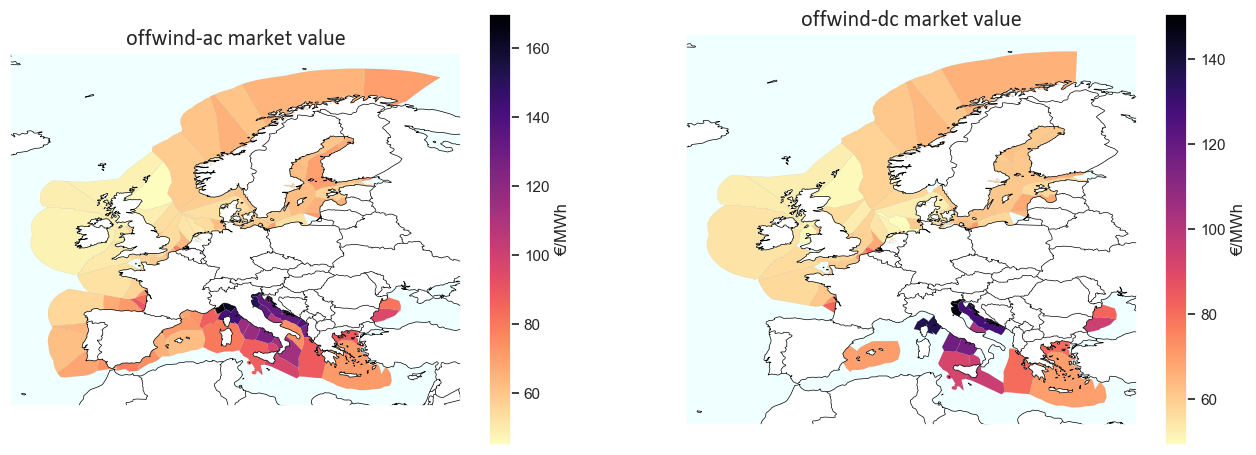

In [226]:
# offshore regions
carrier = "offwind-ac"
labels=["offwind-ac", "offwind-dc" ] # f"{carrier}_gen"

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 14))
crs = ccrs.PlateCarree() #AlbersEqualArea()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{labels[i]} market value", fontsize=16, **font1)

    mv_regions_offshore.to_crs(crs.proj4_init).plot(column=labels[i],
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label':"€/MWh",
                            'orientation': "vertical",
                                      'shrink' : 0.4})
plt.show()

In [227]:
mv_regions_offshore[labels[1]].sort_values(ascending=False)

name
IT0 16    150.621108
IT0 2     147.101850
IT0 8     136.132403
HR0 0     128.425257
IT0 4     117.217259
             ...    
NO3 6            NaN
PT0 0            NaN
PT0 1            NaN
PT0 2            NaN
SI0 0            NaN
Name: offwind-dc, Length: 100, dtype: float64

__Findings__
- __offwind-ac:__ highest mv in ITA, HRO (Croatia); low around UK & at the coastlin of NOR & iside the baltic | high production at the norther coastline of FRA, BEL, NLD & DEU; southcoast of GBR and eastcoast of ROU (Romania) & BGR (Bulgaria) (Black sea)
- __offwind-dc:__ highest mv in ITA, SVN (Slowenia) & MNE (Montenegro) | high production at the norther coastline of BEL, NLD & DEU; southcoast of GBR, westcoast of FIN & GRC| mv of offwind-ac and offwinf-dc are rather similar; generation pattern is quite similar with more generation for offwind-dc

#### DIff(LMP-MV) per region

In [228]:
# get relevant carrier of bus where carrier leads to (generators & links)
carrier = "solar rooftop"
print(f"generator: {n.buses.loc[n.generators[n.generators.carrier == carrier]['bus']]['carrier'].unique()}")
print(f"link: {n.buses.loc[n.links[n.links.carrier == carrier]['bus1']]['carrier'].unique()}")

generator: ['low voltage']
link: []


In [229]:
carrier_bus = 'low voltage' # 'AC' # 'low voltage'

mv = mv_regions_onshore[carrier]
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()

df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
lmp_regions_onshore = mv_regions_onshore[["geometry","coords","name"]].copy().rename(columns={"name": "location"})
lmp_regions_onshore = pd.merge(lmp_regions_onshore,df,on="location").set_index("location")
lmp_regions_onshore[f"diff({carrier_bus}_lmp,{carrier}_mv)"] = (lmp_regions_onshore[f"{carrier_bus}_lmp"] - mv)
lmp_regions_onshore.head(3)

geometry  \
location                                                      
AL0 0     POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0     POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1     POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                            coords  low voltage_lmp  \
location                                                              
AL0 0       (20.00648437943388, 41.14563914300007)       100.338046   
AT0 0     (15.700718667666258, 47.896990619088925)       115.006246   
AT0 1      (10.379200993764837, 47.18231496200006)       121.910720   

          diff(low voltage_lmp,solar rooftop_mv)  
location                                          
AL0 0                                  43.838976  
AT0 0                                  50.543913  
AT0 1                                  44.879266

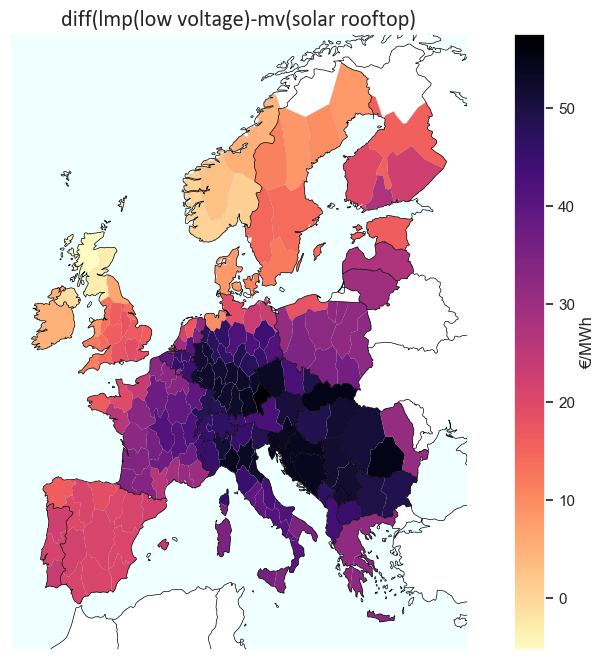

In [230]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"diff(lmp({carrier_bus})-mv({carrier})", fontsize=16, **font1)

lmp_regions_onshore.plot(column=f"diff({carrier_bus}_lmp,{carrier}_mv)",
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

In [231]:
lmp_regions_onshore[f"diff({carrier_bus}_lmp,{carrier}_mv)"].dropna().sort_values(ascending=False)

location
DE0 6     57.585845
RO0 1     54.996060
SK0 0     54.975242
HR0 0     54.081903
DE0 9     53.963500
            ...    
NO3 5      0.461034
GB4 0     -0.953807
GB5 8     -2.899458
GB5 16    -2.979120
GB5 0     -5.342465
Name: diff(low voltage_lmp,solar rooftop_mv), Length: 178, dtype: float64

__Findings:__
- __Implications:__ high positive values mean that the lmp at the bus is on average (weighted by the production) higher than the mv of the technology which means the technology produces at times of lmps that are lower than the average (bad for the technology); high negative values mean that the technology produces disproportionately often if the lmp is relatively high (good for the technology); mv is just a weighted average of the lmp weighted by the generation, the lmp value in this case is just the average lmp over all timesteps
- __["H2","H2 Electrolysis"]:__ high diff in middle and middle-east europe (DEU, ITA, CZE, LUX, ...)
- __["battery","battery charger"]:__ very high diff in middle europe; low diff in NOR and SWE
- __["home battery","home battery charger"]:__ similar to ["battery","battery charger"]
- __["AC","solar"]:__ range(0,60); high in middle and middle-east europa low in scandinavia, UK
- __["AC","onwind"]:__ range(-30,47); high negative values in ITA
- __["AC","offwind-ac"]:__ range(-50,40); high negative values in ITA & adriatic sea, highest positive values in NLD
- __["low voltage","solar rooftop"]:__ range(-5,60); slightly negative values in GBR; verhy high values in middle and middle-east europe (DEU,ROU,HRV)

#### Market values per country

In [232]:
# geopandas country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(["pop_est","gdp_md_est"], axis=1)
# Remove French Guiana from France.
shape = world[world['name'] == 'France']['geometry'].all()
fr_df = pd.Series(['France', 'France'], name='country')
fr_df = gpd.GeoDataFrame(fr_df, geometry=[shape[1], shape[2]])
fr_df = fr_df.dissolve(by='country')
world.geometry[world['name'] == 'France'] = fr_df['geometry'].values
# Remove Svalbard
shape = world[world['name'] == 'Norway']['geometry'].all()
no_df = pd.Series(['Norway'], name='country')
no_df = gpd.GeoDataFrame(no_df, geometry=[shape[1]])
no_df = no_df.dissolve(by='country')
world.geometry[world['name'] == 'Norway'] = no_df['geometry'].values

In [233]:
# convert country codes and map
mv_country_onshore = mv_regions_onshore.drop(["geometry","coords"], axis=1)
mv_country_onshore["country"] = mv_country_onshore.index.str[:2]
mv_country_onshore = mv_country_onshore.groupby(by="country").mean()
mv_country_onshore["iso_a3"] = pd.Index([convert_ISO_3166_2_to_1[cc] for cc in mv_country_onshore.index])
mv_country_onshore=pd.merge(world, mv_country_onshore,on='iso_a3')

mv_country_onshore['coords'] = mv_country_onshore['geometry'].apply(lambda x: x.representative_point().coords[:])
mv_country_onshore['coords'] = [coords[0] for coords in mv_country_onshore['coords']]
mv_country_onshore

continent              name iso_a3  \
0     Europe            Norway    NOR   
1     Europe            France    FRA   
2     Europe            Sweden    SWE   
3     Europe            Poland    POL   
4     Europe           Austria    AUT   
5     Europe           Hungary    HUN   
6     Europe           Romania    ROU   
7     Europe         Lithuania    LTU   
8     Europe            Latvia    LVA   
9     Europe           Estonia    EST   
10    Europe           Germany    DEU   
11    Europe          Bulgaria    BGR   
12    Europe            Greece    GRC   
13    Europe           Albania    ALB   
14    Europe           Croatia    HRV   
15    Europe       Switzerland    CHE   
16    Europe        Luxembourg    LUX   
17    Europe           Belgium    BEL   
18    Europe       Netherlands    NLD   
19    Europe          Portugal    PRT   
20    Europe             Spain    ESP   
21    Europe           Ireland    IRL   
22    Europe             Italy    ITA   
23    Europe           Denmark    DNK   
24    Europe    United Kingdom    GBR   
25    Europe          Slovenia    SVN   
26    Europe           Finland    FIN   
27    Europe          Slovakia    SVK   
28    Europe           Czechia    CZE   
29    Europe  Bosnia and Herz.    BIH   
30    Europe   North Macedonia    MKD   
31    Europe            Serbia    SRB   
32    Europe        Montenegro    MNE   

                                             geometry  offwind-ac  \
0   POLYGON ((31.10104 69.55810, 29.39955 69.15692...   60.821353   
1   MULTIPOLYGON (((9.39000 43.00998, 9.56002 42.1...   69.024474   
2   POLYGON ((11.02737 58.85615, 11.46827 59.43239...   60.779603   
3   POLYGON ((23.48413 53.91250, 23.52754 53.47012...   61.489763   
4   POLYGON ((16.97967 48.12350, 16.90375 47.71487...         NaN   
5   POLYGON ((22.08561 48.42226, 22.64082 48.15024...         NaN   
6   POLYGON ((28.23355 45.48828, 28.67978 45.30403...   81.190049   
7   POLYGON ((26.49433 55.61511, 26.58828 55.16718...   70.469416   
8   POLYGON ((27.28818 57.47453, 27.77002 57.24426...   65.430620   
9   POLYGON ((27.98113 59.47537, 27.98112 59.47537...   56.147002   
10  POLYGON ((14.11969 53.75703, 14.35332 53.24817...   59.407815   
11  POLYGON ((22.65715 44.23492, 22.94483 43.82379...   95.498412   
12  MULTIPOLYGON (((26.29000 35.29999, 26.16500 35...   79.905399   
13  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  126.148417   
14  POLYGON ((16.56481 46.50375, 16.88252 46.38063...  132.260889   
15  POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...         NaN   
16  POLYGON ((6.04307 50.12805, 6.24275 49.90223, ...         NaN   
17  POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...   78.122119   
18  POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...   58.423510   
19  POLYGON ((-9.03482 41.88057, -8.67195 42.13469...   64.771007   
20  POLYGON ((-7.45373 37.09779, -7.53711 37.42890...   68.504326   
21  POLYGON ((-6.19788 53.86757, -6.03299 53.15316...   48.046259   
22  MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...  121.661564   
23  MULTIPOLYGON (((9.92191 54.98310, 9.28205 54.8...   55.165798   
24  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...   52.014777   
25  POLYGON ((13.80648 46.50931, 14.63247 46.43182...  148.386481   
26  POLYGON ((28.59193 69.06478, 28.44594 68.36461...   67.637634   
27  POLYGON ((22.55814 49.08574, 22.28084 48.82539...         NaN   
28  POLYGON ((15.01700 51.10667, 15.49097 50.78473...         NaN   
29  POLYGON ((18.56000 42.65000, 17.67492 43.02856...         NaN   
30  POLYGON ((22.38053 42.32026, 22.88137 41.99930...         NaN   
31  POLYGON ((18.82982 45.90887, 18.82984 45.90888...         NaN   
32  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  138.426166   

    offwind-ac_gen      onwind    onwind_gen      solar     solar_gen  ...  \
0     9.213995e+01   56.821417  2.028227e+06  62.437041  9.832202e+01  ...   
1     2.884109e+05   65.818584  8.784395e+06  52.791854  4.748776e+06  ...   
2     1.156796e+02   55.384

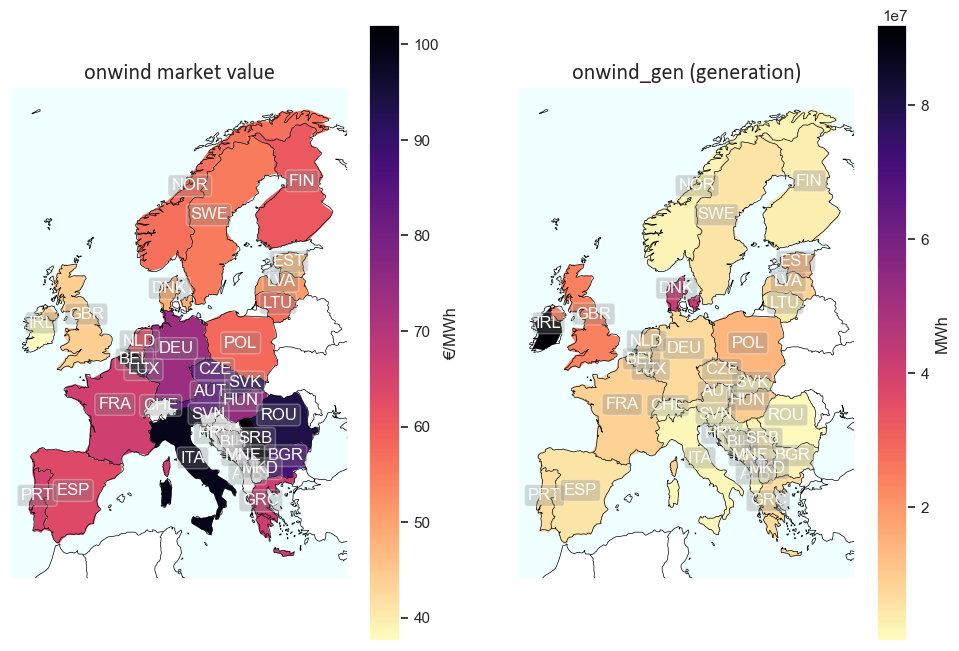

In [234]:
# compare two carriers
carriers=["onwind", "onwind_gen"]

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12, 8))

for i, ax in enumerate(axs):

    if i == 0:
        title=f"{carriers[i]} market value"
        label="€/MWh"
    else:
        title=f"{carriers[i]} (generation)"
        label="MWh"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(title, fontsize=16, **font1)

    mv_country_onshore.plot(column=carriers[i],
                         ax=ax,
                         transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'label': label,
                            'orientation': "vertical"})

    for idx, row in mv_country_onshore.iterrows():
        ax.annotate(text=row['iso_a3'], xy=row['coords'], color='white',
                     bbox=dict(boxstyle='round,pad=0.2', fc='grey', alpha=0.3),
                     horizontalalignment='center')

plt.show()

In [235]:
# carriers for which market_values function does not work
# -> there are 24 carrier which are not a generators but attached to a bus; from the generators only 2 are also attached to buses {'gas', 'oil'}
# all renewables are produced at generators and are not directly attached to a bus; the generator is attached to the bus (thats also why they do not have lmps)
# set(n.buses.carrier.tolist()) - set(n.generators.carrier.tolist()) # 24

In [236]:
# fig.savefig(f"{PLOT_DIR}mv_country.png")

### Spatial and temporal distribution of prices:

- electricity
- heat (various subcategories)
- hydrogen

#### Nodal Prices for every time step (sum) - heatmap (temporal distribution)

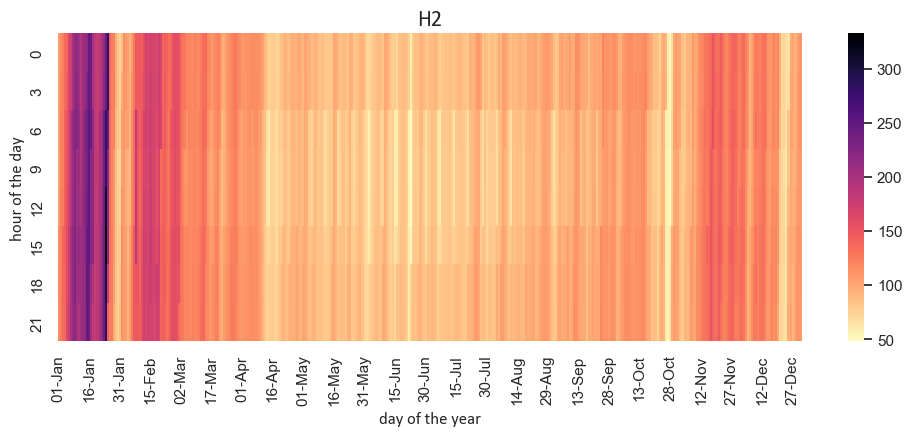

In [237]:
carrier = "H2" # "battery" # "Li ion" # H2, services rural heat, low voltage (no values for VRE as they do not have their own buses)

# change to mean for investigating in mean (unit: €/MWh)
df = pd.DataFrame(n.buses_t.marginal_price[n.buses[n.buses.carrier==carrier].index].mean(axis=1))

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 4))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15)
plt.title(str(carrier), fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

__Findings:__
- __H2:__ no clear pattern during the day; seasonal pattern as higher lmps in the winter with increasing lpms during winter from Nov-Jan; rather constant during summer
- __battery:__ cheaper from hour 6 to 12; higher lmps in winter (Nov-Mar) with highest in Jan; rather constant during summer with some more expensive days
- __Li ion:__ same as battery (also same magnitude)
- __low voltage:__ similar to battery with a hgher magnitude in range(0,700)
- __services rural heat:__ range(0,900); most expensive in hours 3,6 and 18; very low values during warmer months (Apr-Oct); highest lmps in Jan
- __urban central heat:__ range(0,130); clear daily pattern: lower in night (hours: 21,0) and during midday (hours: 9,12) and higher in the morning and afternoon; lower in warmer months (Apr-Sep) and higest lmps in winter (Nov-Mar)

#### Lmps per region (spatial distribution)

In [238]:
carrier_bus = "low voltage"
locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
lmp_regions_onshore = mv_regions_onshore[["geometry","coords","name"]].copy().rename(columns={"name": "location"})
lmp_regions_onshore = pd.merge(lmp_regions_onshore,df,on="location").set_index("location")
lmp_regions_onshore.head(3)

geometry  \
location                                                      
AL0 0     POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0     POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1     POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                            coords  low voltage_lmp  
location                                                             
AL0 0       (20.00648437943388, 41.14563914300007)       100.338046  
AT0 0     (15.700718667666258, 47.896990619088925)       115.006246  
AT0 1      (10.379200993764837, 47.18231496200006)       121.910720

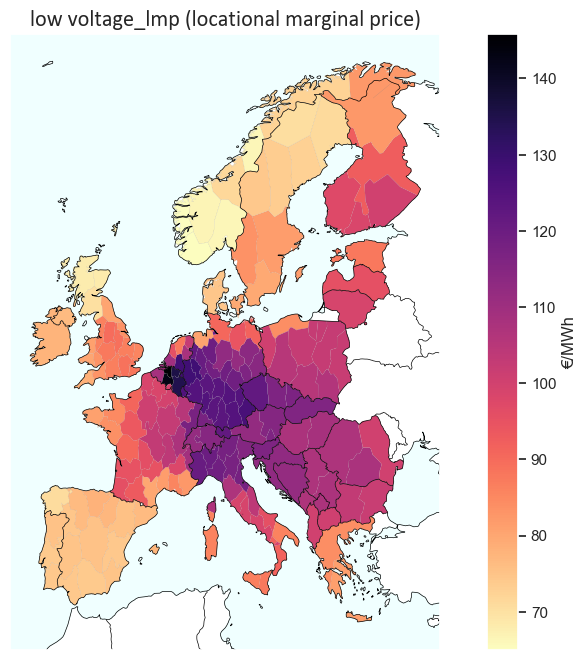

In [239]:
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection=ccrs.PlateCarree()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier_bus}_lmp (locational marginal price)", fontsize=16, **font1)

lmp_regions_onshore.plot(column=f"{carrier_bus}_lmp",
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€/MWh",
                        'orientation': "vertical"})

plt.show()

#### GIF

##### days

carrier = "onwind"
df = market_values_by_time_index(n, days, carrier)
df = df.apply(pd.to_numeric)

for day in days:

    fig = plt.figure(figsize=(10, 8))

    crs = ccrs.AlbersEqualArea()
    ax = plt.axes(projection=ccrs.AlbersEqualArea())
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    ax.set_title(f"{carrier} market value @ {day.date()} in €/MWh", fontsize=22, **font1)

    df2 = onshore_regions.copy()
    df2[carrier] = df.loc[day]

    df2.to_crs(crs.proj4_init).plot(column=carrier,
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'orientation': "vertical",
                            'shrink' : 1}
                                    )
    fig.tight_layout()
    fig.savefig(f"{PLOT_DIR}\GIF\onwind_mv\days\mv_onwind_{day.date()}.png")
    plt.close()

##### weeks

carrier = "onwind"
weeks = np.arange(1,53,1)

for week in weeks:

    fig = plt.figure(figsize=(10, 8))

    crs = ccrs.AlbersEqualArea()
    ax = plt.axes(projection=ccrs.AlbersEqualArea())
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if week < 10:
        week_title = f"0{week}"
    else:
        week_title = week

    ax.set_title(f"{carrier} market value @ week {week_title} (from {n.generators_t.p[n.generators_t.p.index.week == week].index[0].date().strftime('%b %d')}) in €/MWh", fontsize=18, **font1)

    # calc mv
    gen = n.generators_t.p.loc[n.generators_t.p.index.week == week, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[n.buses_t.marginal_price.index.week == week, gen.columns]
    mv = (gen * lmp).sum() / gen.sum()
    mv.index = mv.index.map(n.buses.location)
    df = onshore_regions.copy()
    df[carrier] = mv

    df.to_crs(crs.proj4_init).plot(column=carrier,
                         ax=ax,
                         cmap=plt.get_cmap("magma_r"),
                         linewidth=0.05,
                         edgecolor = 'grey',
                         legend=True,
                         legend_kwds={'orientation': "vertical",
                            'shrink' : 1}
                                    )
    fig.tight_layout()
    fig.savefig(f"{PLOT_DIR}\GIF\onwind_mv\weeks\mv_onwind_week{week}.png")
    plt.close()

### Time series analysis

- when do different technologies produce?
- when are their revenues created? (nodal price * production)
- what are the prices when they produce?


#### Technology Operation and Revenue by Price band

In [241]:
# plot percentage of production per price band and percentage of revenue per price band
carriers_gen = ["onwind", "solar", "ror", "offwind-dc"]
carriers_link = ["OCGT", "H2 Electrolysis", "H2 Fuel Cell", "urban central gas CHP"]
carriers_labels = (carriers_gen + carriers_link)
price_bands = [0, 5, 50, 100, 200, 1000, np.inf]
price_bands_labels = ["0 - 5", "5 - 50", "50 - 100", "100 - 200", "200 - 1000", "> 1000"]
res_prod = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)
res_rev = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers_labels)

In [242]:
for carrier in carriers_gen:
    gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

for carrier in carriers_link:
    # prices of the generated energy
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp

    for i in range(len(price_bands)-1):
        lmp_cat = lmp.mask((lmp >= price_bands[i]) & (lmp < price_bands[i+1]), "hit")
        res_prod.loc[str(i), carrier] = gen[lmp_cat == "hit"].sum().sum() / gen.sum().sum()
        res_rev.loc[str(i), carrier] = rev[lmp_cat == "hit"].sum().sum() / rev.sum().sum()

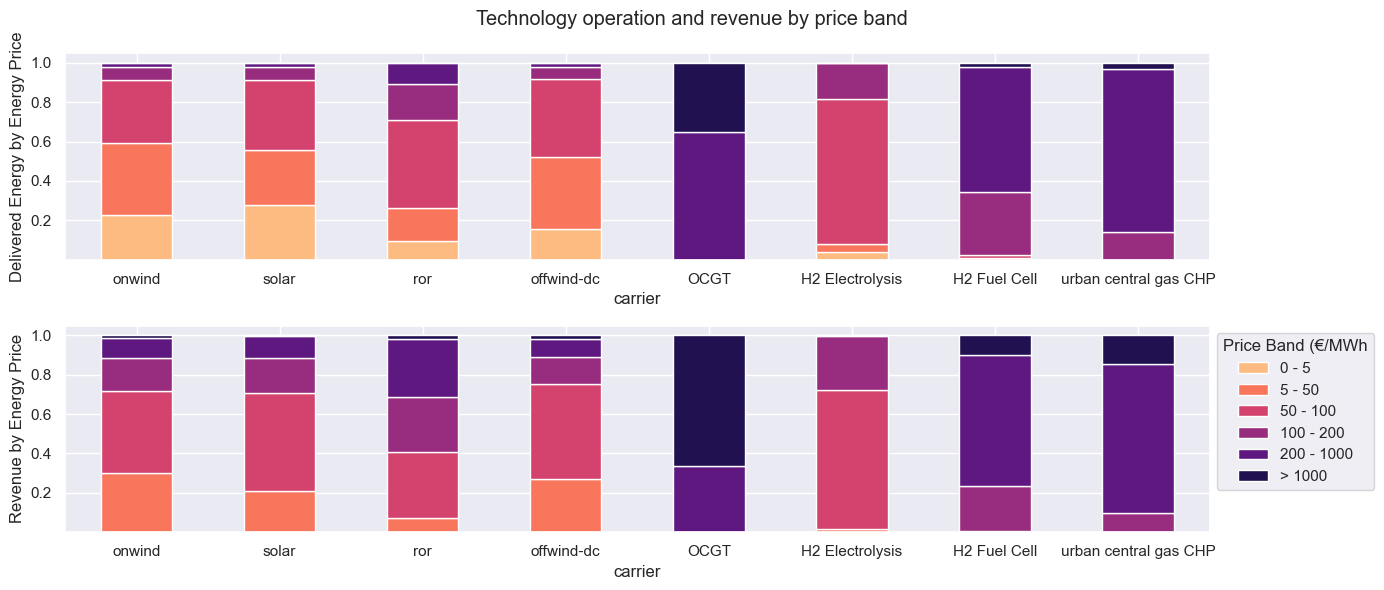

In [243]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

fig.suptitle('Technology operation and revenue by price band')

ax0 = res_prod.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

ax1 = res_rev.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers_labels)), labels=carriers_labels, rotation=0)

fig.tight_layout()

__Findings:__
- Implications:
- __onwind:__ 20 % energy deiverd in band 1 but almost no ipact on revenue; price bands 1-3 account for over 90% of delivered energy but only for 70% of the revenue stream; price bands 4 & 5 account for less than 10 % of delivered energy but for 30 % of revenues
- __solar:__ similar to onwind
- __ror:__ General higher production in more expensive price bands 1-3 account for 70 % of production but only for 40 % of revenue
- __H2 Electrolysis:__ production mostly within price bands 3 & 4 and revenue almost only in price band 3 & 4

#### Energy conversion technologies production and revenue by input technology price band (links)

In [244]:
carriers = car_link_mix

res_prod2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)
res_rev2 = pd.DataFrame(index=[str(s) for s in range(len(price_bands)-1)], columns=carriers)

In [245]:
for carrier in carriers:
# prices of the consumed energy
    con = n.links_t.p0.loc[:, n.links.carrier == carrier]
    transform_columns = n.links_t.p0.loc[:, n.links.carrier == carrier].columns.map(n.links.bus1)
    con.columns = con.columns.map(n.links.bus0)
    lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
    cost = con * lmp_con

    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    gen.columns = gen.columns.map(n.links.bus1)
    lmp_gen = n.buses_t.marginal_price.loc[:, gen.columns]
    rev = gen * lmp_gen

    for i in range(len(price_bands)-1):
        lmp_cat1 = lmp_con.mask((lmp_con >= price_bands[i]) & (lmp_con < price_bands[i+1]), "hit")
        # pay attention to indices (if something went wrong then probably here)
        lmp_cat1.columns = transform_columns
        res_prod2.loc[str(i), carrier] = gen[lmp_cat1 == "hit"].sum().sum() / gen.sum().sum()
        res_rev2.loc[str(i), carrier] = rev[lmp_cat1 == "hit"].sum().sum() / rev.sum().sum()

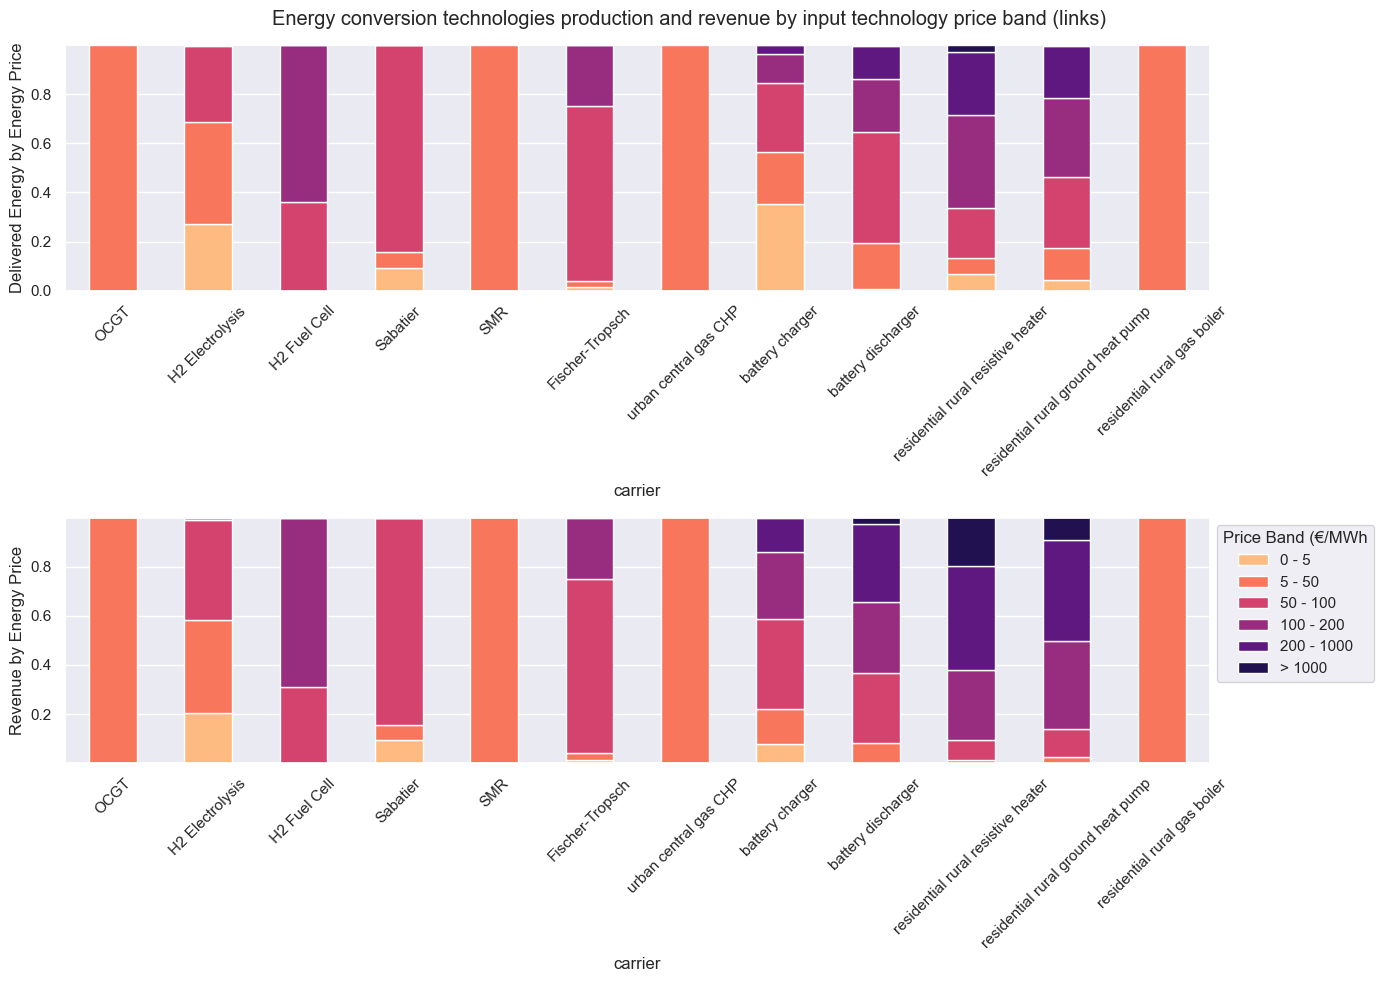

In [246]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

fig.suptitle('Energy conversion technologies production and revenue by input technology price band (links) ')

ax0 = res_prod2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[0], legend=False)
ax0.set_ylabel("Delivered Energy by Energy Price")
ax0.set_xlabel("carrier")
ax0.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

ax1 = res_rev2.transpose().plot(kind='bar', stacked=True, color=sns.color_palette("magma_r", 6), ax=axes[1])
ax1.legend(title='Price Band (€/MWh', labels=price_bands_labels, bbox_to_anchor=(1, 1))
ax1.set_ylabel("Revenue by Energy Price")
ax1.set_xlabel("carrier")
ax1.set_xticks(ticks=range(len(carriers)), labels=carriers, rotation=45)

fig.tight_layout()

__Findings:__
- ...

### Congestion rent
Additionally: Calculate congestion rents for link components: price difference i-j * flow i-j
ToDo: maybe also for line components?

In [247]:
# congestion rent makes only sense if link has only 2 buses; definition of cr is otherwise unclear
carriers = n.links.carrier[n.links.bus3 == ""].unique()
cr_res1 = pd.DataFrame(index = range(1), columns=carriers)

for carrier in carriers:
    cr_res1[carrier] = congestion_rent_link(n,carrier).sum().sum()

In [248]:
cr_res1 = cr_res1.sort_values(by=0, axis='columns', ascending=False)

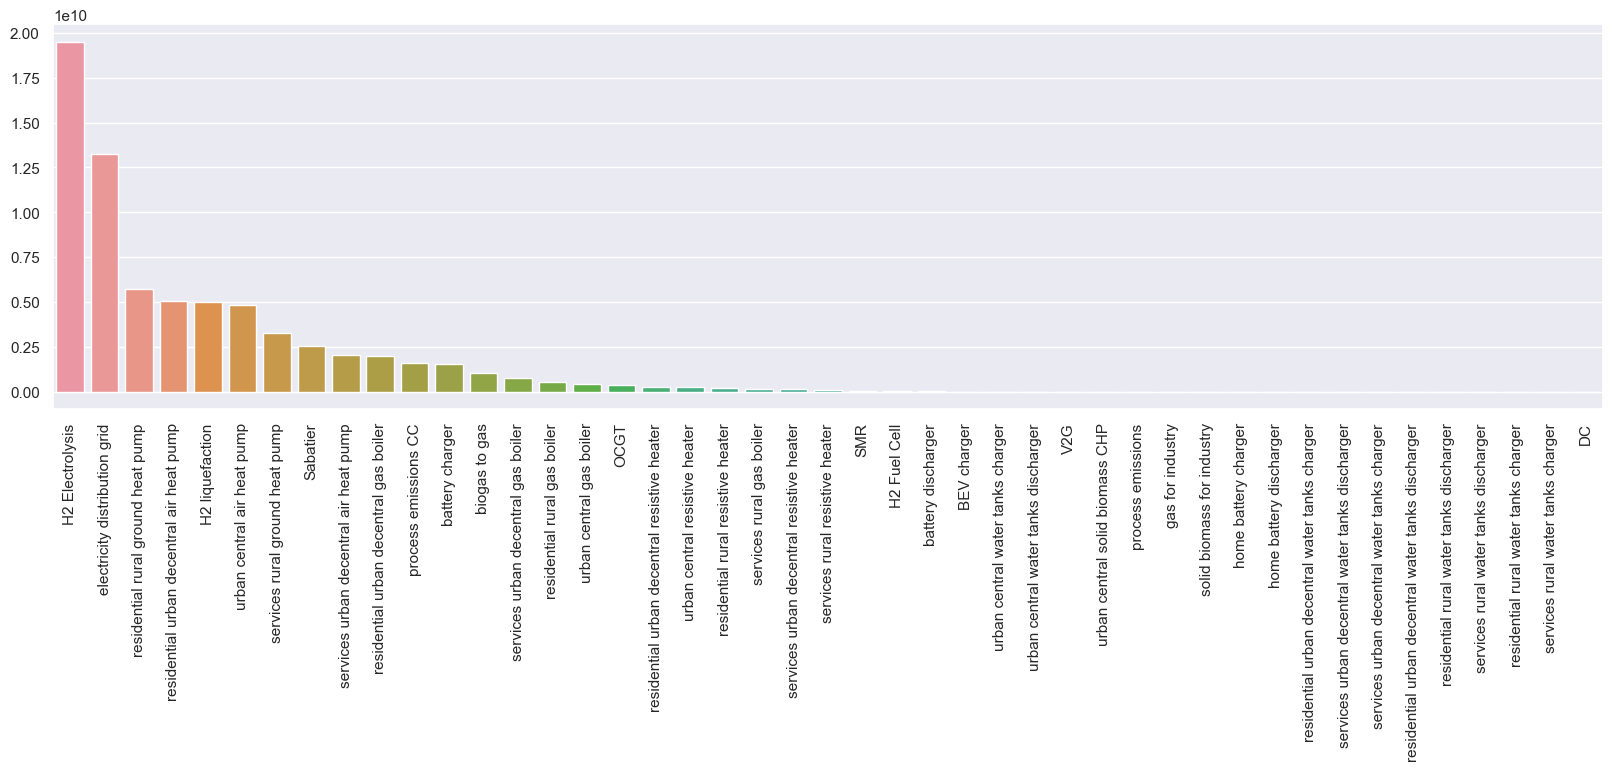

In [249]:
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(data=cr_res1)
ticks = plt.xticks(rotation=90)

__Findings__
- negative values for some technologies: OCGT, water tanks, battery charger but in much smaller magnitude than positive values (maybe due to numeric inaccuracy?)

In [250]:
# Congestion rent by region
cr_regions_onshore = onshore_regions.copy().rename(columns={"name": "location"})

for carrier in carriers:
    cr_regions = congestion_rent_link(n,carrier).sum()

    if n.buses.loc[cr_regions.index.map(n.links.bus0)].location.values[0] == 'EU':
        bus = "bus1"
    else:
        bus = "bus0"

    cr_regions = pd.concat([cr_regions,n.links.loc[cr_regions.index][bus]], axis=1).rename(columns={0: f"{carrier}_cr"})
    cr_regions["location"] = n.buses.loc[cr_regions.index.map(n.links[bus])].location.values
    # for some carrier e.g. "DC" the locations occur several times in the index -> take sum
    cr_regions = cr_regions.groupby(by=["location"], axis="index").sum()
    cr_regions_onshore[f"{carrier}_cr"] = cr_regions[f"{carrier}_cr"]
cr_regions_onshore.head(3)
    # TODO: For plotting the cr into a map which bus should be used? bus0, where the energy comes from or bus1 where the energy goes to? For some carriers e.g. Fischer-Tropsch they are not in the same region (EU bus)

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   

                                         coords location  DC_cr      OCGT_cr  \
name                                                                           
AL0 0    (20.00648437943388, 41.14563914300007)    AL0 0    NaN    33.119340   
AT0 0  (15.700718667666258, 47.896990619088925)    AT0 0    NaN    95.440126   
AT0 1   (10.379200993764837, 47.18231496200006)    AT0 1    NaN  2507.759207   

       H2 Electrolysis_cr  H2 Fuel Cell_cr  battery charger_cr  \
name                                                             
AL0 0        5.753717e+07      -367.767894        3.464495e+07   
AT0 0        5.961820e+07      -365.643646        2.660615e+04   
AT0 1        2.992512e+06      -537.693753        7.541187e+06   

       battery discharger_cr   Sabatier_cr  ...  biogas to gas_cr  \
name                                        ...                     
AL0 0           34956.799709  1.342660e+07  ...               NaN   
AT0 0            1048.041194  3.348849e+06  ...               NaN   
AT0 1          138762.719384  9.170989e+04  ...               NaN   

       urban central solid biomass CHP_cr  solid biomass for industry_cr  \
name                                                                       
AL0 0                         1278.787475                            NaN   
AT0 0                         1375.459198                            NaN   
AT0 1                         1182.530598                            NaN   

       gas for industry_cr  H2 liquefaction_cr  process emissions_cr  \
name                                                                   
AL0 0                  NaN        1.891549e+06                   NaN   
AT0 0                  NaN        1.354453e+06                   NaN   
AT0 1                  NaN        1.631584e+05                   NaN   

       process emissions CC_cr  electricity distribution grid_cr  \
name                                                               
AL0 0                      NaN                      1.401134e+07   
AT0 0                      NaN                      1.486700e+08   
AT0 1                      NaN                      1.775257e+07   

       home battery charger_cr  home battery discharger_cr  
name                                                        
AL0 0              -352.001211                 -499.663643  
AT0 0              -429.846793                 -540.031913  
AT0 1              -416.792987                 -512.694656  

[3 rows x 48 columns]

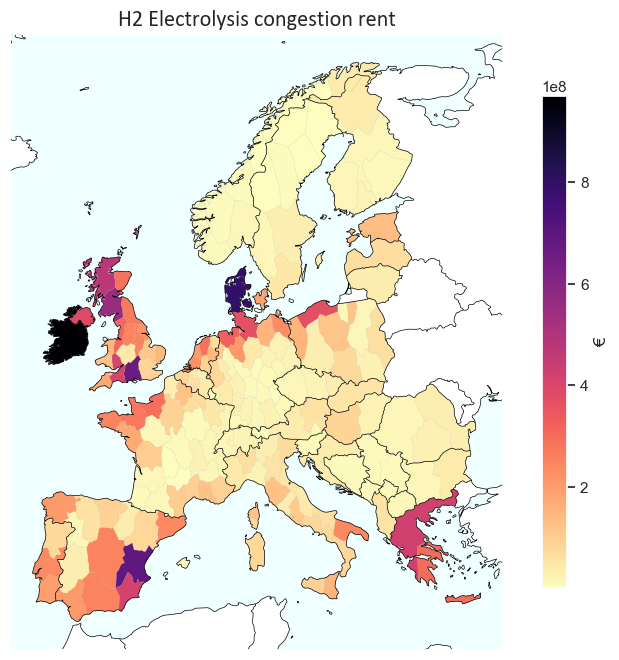

In [251]:
carrier = "H2 Electrolysis"

fig = plt.figure(figsize=(10, 8))

crs = ccrs.AlbersEqualArea()
ax = plt.axes(projection=ccrs.AlbersEqualArea()) # Mercator
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title(f"{carrier} congestion rent", fontsize=16, **font1)

cr_regions_onshore.to_crs(crs.proj4_init).plot(column=f"{carrier}_cr",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"€",
                        'orientation': "vertical",
                                  'shrink' : 0.8})

plt.show()
# TODO: Would be interesting to plot a map with the location of the capacity of the corresponding carrier next to it; probably there is a correlation between higher capacity and higher cr

In [252]:
cr_regions_onshore[f"{carrier}_cr"].sort_values(ascending=False)

name
IE4 0     9.697672e+08
DK0 0     7.952162e+08
ES0 8     6.874895e+08
GB5 10    6.660884e+08
GB5 16    5.563028e+08
              ...     
SE3 1     2.215760e+06
NO3 1     2.166030e+06
SE3 5     2.047534e+06
SE3 7     1.280374e+06
SE3 4     1.087271e+06
Name: H2 Electrolysis_cr, Length: 181, dtype: float64

__Findings:__
- __H2 Electrolysis:__  Highest values in IRL, GBR and DNK; General higher values in the coastal area of mainland Europe (PRT, ESP, FRA, NLD, DEU, POL, GRC); very low values in the inner mainland and scandinavia
- __electricity distribution grid:__ no strong pattern; highest values for north/middle (FR0 1) and GB5 13; there might be soe correlation with higher cr in population-intensive regions an
- __Fischer-Tropsch:__ Comparable to H2 Electrolysis; Highest values in DNK & GBR; especialle higher values on the resource receiving party of the european coastline (Atlantic coast and GRC)
- __urban central solid biomass CHP CC:__ High values for parts of DEU, CZE, AUT, ITA, SVK & HUN; Very low values for west europe UK and scandinavia
- residential rural ground heat pump:
- residential urban decentral air heat pump:
- H2 liquefaction:
- urban central air heat pump:
- urban central gas CHP:

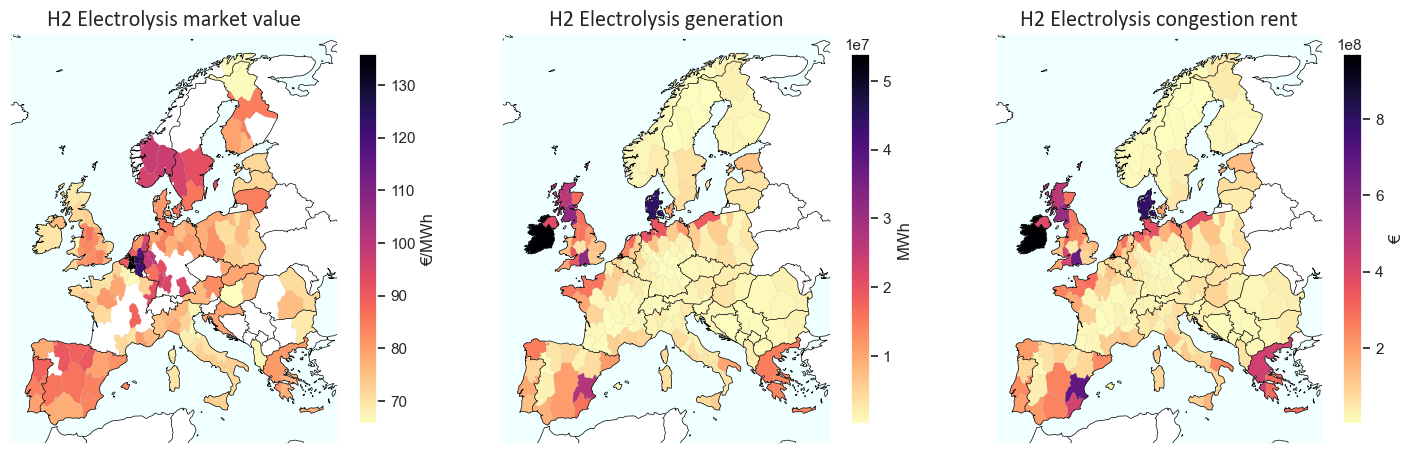

In [253]:
# summarising plot with mv, gen and cr
carrier="H2 Electrolysis"
# "battery discharger" # "battery charger" # "H2 Fuel Cell" #"Fischer-Tropsch" #"OCGT" #H2 Electrolysis" # H2 Electrolysis, H2 Fuel Cell
carriers=[carrier , f"{carrier}_gen", f"{carrier}_cr"]

fig, axs = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.AlbersEqualArea()},
                        figsize=(18, 16))
crs = ccrs.AlbersEqualArea()

for i, ax in enumerate(axs):
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    if i==0:
        title = f"{carrier} market value"
        label = "€/MWh"
        df = mv_regions_onshore
    elif i==1:
        title = f"{carrier} generation"
        label = "MWh"
        df = mv_regions_onshore
    else:
        title = f"{carrier} congestion rent"
        label = "€"
        df = cr_regions_onshore

    args = dict(column=carriers[i],
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':label,
                        'orientation': "vertical",
                                  'shrink' : 0.3}
                )

    ax.set_title(title, fontsize=16, **font1)
    df.to_crs(crs.proj4_init).plot(**args)

plt.show()

### ToDo

- market value per carrier per country plot
- market value aggregated over carriers per country/region plot